In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd

from scipy.io import loadmat

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

import scipy.stats as stats
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import plotly.express as px

In [2]:
# domain adaptation task
# Task 0 −→ 1 means working load 0 is the source domain with labeled training samples, and
# working load 1 is the target domain we want to improve model performance on.
src = 3
tgt = 2

In [3]:
orrd = pd.DataFrame([
        ['100', 3, 0],
        ['108', 3, 1],
        ['172', 3, 2],
        ['212', 3, 3],
        ['133', 3, 4],
        ['200', 3, 5],
        ['237', 3, 6],
        ['121', 3, 7],
        ['188', 3, 8],
        ['225', 3, 9],
                                  
        ['099', 2, 0],
        ['107', 2, 1],
        ['171', 2, 2],
        ['211', 2, 3],
        ['132', 2, 4],
        ['199', 2, 5],
        ['236', 2, 6],
        ['120', 2, 7],
        ['187', 2, 8],
        ['224', 2, 9],
        
        ['098', 1, 0],
        ['106', 1, 1],
        ['170', 1, 2],
        ['210', 1, 3],
        ['131', 1, 4],
        ['198', 1, 5],
        ['235', 1, 6],
        ['119', 1, 7],
        ['186', 1, 8],
        ['223', 1, 9],
        
        ['097', 0, 0],
        ['105', 0, 1],
        ['169', 0, 2],
        ['209', 0, 3],
        ['130', 0, 4],
        ['197', 0, 5],
        ['234', 0, 6],
        ['118', 0, 7],
        ['185', 0, 8],
        ['222', 0, 9]], columns = ['name','load','label'])

In [4]:
# returns data and labels
def cwru_data(load, percentage, truncate=120000, length=1024, sample=200, shuffle=False):
    out = []
    data_out = []
    lbls = []

    for ii in orrd[orrd['load']==load]['name'].index:
    # loading the .mat - lbl can be [0,1,2,3,4,5,6,7,8,9] when percentage="all" 
    # or [0,1] when percentage="20%"
        
        lbl = orrd.iloc[ii]['label']
        file_number = orrd.iloc[ii]['name']
#         print(file_number)
        file_dirs = 'C:/Users/lucas/Documents/Doutorado/WorkSpace/DADOS CWRU/01_Raw/' + file_number + '.mat'
        data = loadmat(file_dirs)
        for i in data:
            # taking only the DE list of values
            if "X{}_DE_time".format(file_number) == i:
#                 print("OK!")
#                 print(i)
#                 for j in range(0, len(data) - length + 1 , (len(data) - length)//(sample - 1) ):
#                     print(j)
                if file_number in ['097', '098', '099', '100']:
                    print('filtro', file_number)
                    data[i] = data[i][1::4]
                data = data[i][:truncate] # truncating the length of data
                data = [data[j:j + length] for j in range(0, len(data) - length + 1 , (len(data) - length)//(sample - 1) )] # sampling
                #data = np.lib.stride_tricks.sliding_window_view(data.reshape(truncate),1024)[::1024, :]
                    
                # carrying out fft
                for k in range(0,len(data)):
                    data_out.append(data[k])
                    fft = abs(np.fft.fft(data[k])[:len(data[k])//2])
                    out.append(fft)
                    lbls.append([lbl])
            else:
                pass

    # one hot encoding
    #lbls = to_categorical(np.array(lbls))

    return data_out, np.array(out), np.array(lbls)

In [5]:
# preparing data for stage 1
data, data_fft, labels = cwru_data(load=src, percentage="full", shuffle=True)
data_tgt, data_fft_tgt, labels_tgt = cwru_data(load=tgt, percentage="full", shuffle=True)

data_src = np.array(data).reshape(2000,1024)
data_src = data_src
label_src = np.array(labels).reshape(2000)

data_tgt = np.array(data_tgt).reshape(2000,1024)
data_tgt = data_tgt
label_tgt = np.array(labels_tgt).reshape(2000)

print("Source dimension", data_src.shape, label_src.shape)
print("Target dimension", data_tgt.shape, label_tgt.shape)

filtro 100
filtro 099
Source dimension (2000, 1024) (2000,)
Target dimension (2000, 1024) (2000,)


In [6]:
fft = lambda sig: abs(np.fft.fft(sig)[0:len(sig)//2])/len(sig)
#fft = lambda sig: abs(np.fft.fft(sig)[0:len(sig)//2])

data_src_fft = np.array([fft(sig) for sig in data_src])
data_src_fft[1:] = data_src_fft[1:]*2

data_tgt_fft = np.array([fft(sig) for sig in data_tgt])
data_tgt_fft[1:] = data_tgt_fft[1:]*2

print("Source dimension", data_src_fft.shape, label_src.shape)
print("Target dimension", data_tgt_fft.shape, label_tgt.shape)

Source dimension (2000, 512) (2000,)
Target dimension (2000, 512) (2000,)


In [ ]:
### Expand the last dimension for ease of feeding conv1d
# data_src = np.expand_dims(data_src, axis=-1)
# data_src_fft = np.expand_dims(data_src_fft, axis=-1)
# data_tgt = np.expand_dims(data_tgt, axis=-1)
# data_tgt_fft = np.expand_dims(data_tgt_fft, axis=-1)
# print("Source dimension", data_src_fft.shape, data_src.shape)
# print("Target dimension", data_tgt_fft.shape, data_tgt.shape)

# Random Forest 

In [7]:
# train test Split
(data_src_fft_train, data_src_fft_test, 
label_src_train, label_src_test) = train_test_split(data_src_fft, label_src, test_size=0.33, random_state=42)
print(data_src_fft_train.shape,
        data_src_fft_test.shape,
        label_src_train.shape,
        label_src_test.shape)

(data_tgt_fft_train, data_tgt_fft_test, 
label_tgt_train, label_tgt_test) = train_test_split(data_tgt_fft, label_tgt, test_size=0.33, random_state=42)
print(data_tgt_fft_train.shape,
        data_tgt_fft_test.shape,
        label_tgt_train.shape,
        label_tgt_test.shape)

(1340, 512) (660, 512) (1340,) (660,)
(1340, 512) (660, 512) (1340,) (660,)


In [30]:
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(data_src_fft_train, label_src_train)

RandomForestClassifier(max_depth=5, random_state=0)

In [43]:
clf.estimator_params[0]

'criterion'

In [31]:
clf.score(data_src_fft_train, label_src_train)

1.0

In [32]:
clf.score(data_src_fft_test, label_src_test)

1.0

In [33]:
clf.score(data_tgt_fft_test, label_tgt_test)

0.7121212121212122

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

In [ ]:
y_pred = clf.predict(data_tgt_fft_test)
y_test = label_tgt_test

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

In [ ]:
clf.estimators_[0]

In [9]:
# Number of trees in random forest
n_estimators = np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)

# Maximum number of levels in tree
max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200]

# Minimum number of samples required to split a node
# min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 9)]
min_samples_split = [1, 2, 5, 10, 15, 20, 30]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Criterion
criterion=['gini', 'entropy']
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}

In [10]:
from sklearn.model_selection import RandomizedSearchCV

In [11]:
rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 30, cv = 5,
                               verbose=2,
                               random_state=42, n_jobs = 4)
rf_random.fit(data_src_fft_train, label_src_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\lucas\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lucas\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lucas\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\lucas\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\lucas\anaconda3\lib\site-packages\j

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=30,
                   n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 5, 10, 20, 50, 75, 100,
                                                      150, 200],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [1, 2, 5, 10, 15,
                                                              20, 30],
                                        'n_estimators': array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
       2378, 2585, 2792, 3000])},
                   random_state=42, verbose=2)

In [12]:
rf_random.best_params_

{'n_estimators': 2171,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 200,
 'criterion': 'entropy',
 'bootstrap': True}

In [13]:
rf_random.score(data_src_fft_train, label_src_train)

1.0

In [14]:
rf_random.score(data_src_fft_test, label_src_test)

1.0

In [15]:
rf_random.score(data_tgt_fft_test, label_tgt_test)

0.7803030303030303

In [16]:
y_pred = rf_random.predict(data_tgt_fft_test)
y_test = label_tgt_test

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7803030303030303
Precision: 0.7765651333450554
Recall: 0.8054054054054054


C:\Users\lucas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [ ]:
rf_random.

In [ ]:
for i in range(3):
    tree = clf.estimators_[i]
    dot_data = export_graphviz(tree,
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [ ]:
stats.ttest_ind(accs_base_tgt, accs_tgt)

In [ ]:
np.savetxt("./logs/T{}{}_test_t.csv".format(src,tgt), np.array(stats.ttest_ind(accs_base_tgt, accs_tgt)), delimiter=";")

In [20]:
pred = rf_random.predict(data_src_fft)

In [21]:
pred

array([0, 0, 0, ..., 9, 9, 9], dtype=int64)

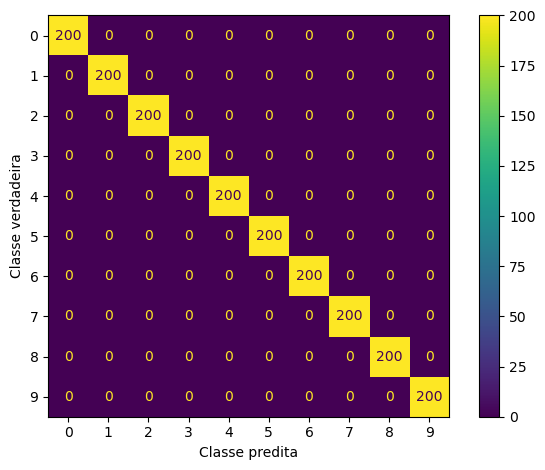

In [34]:
pred = clf.predict(data_src_fft)
#pred = [np.argmax(x) for x in pred]

cm = confusion_matrix(label_tgt, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=np.unique(label_tgt))
disp.plot()
plt.xlabel('Classe predita')
plt.ylabel('Classe verdadeira')
plt.tight_layout()
plt.savefig('./imagens/T{}{}_confusion matrix source validation DANN.jpg'.format(src, tgt),
           dpi = 600)
plt.show()

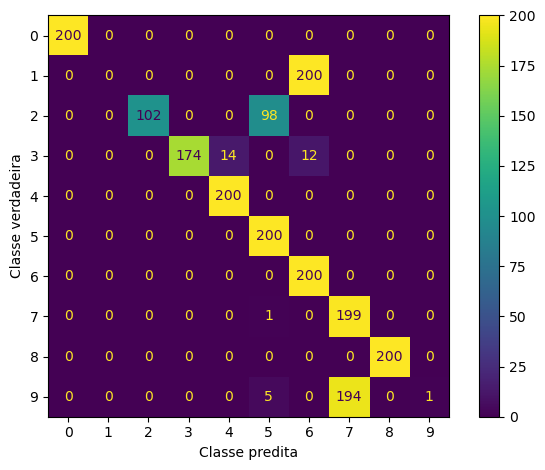

In [35]:
pred = clf.predict(data_tgt_fft)
#pred = [np.argmax(x) for x in pred]

cm = confusion_matrix(label_tgt, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=np.unique(label_tgt))
disp.plot()
plt.xlabel('Classe predita')
plt.ylabel('Classe verdadeira')
plt.tight_layout()
plt.savefig('./imagens/T{}{}_confusion matrix target validation DANN.jpg'.format(src, tgt),
           dpi = 600)
plt.show()

# Feature Factors 

In [ ]:
clf_branch.summary()

In [ ]:
feature_output = Model(clf_branch.input, clf_branch.get_layer('feature').output)

In [ ]:
feture_pred = feature_output(data_src_fft)
feture_pred.shape

In [ ]:
feture_pred_tgt = feature_output(data_tgt_fft)
feture_pred_tgt

# PCA

In [ ]:
pca = PCA(n_components=7)
pca_model = pca.fit(np.array(feture_pred))
Xfactor_train_source = pca_model.transform(np.array(feture_pred))
Xfactor_train_target = pca_model.transform(np.array(feture_pred_tgt))

In [ ]:
Xfactor_source = pd.DataFrame(Xfactor_train_source).reset_index(drop=True)
Xfactor_target = pd.DataFrame(Xfactor_train_target).reset_index(drop=True)
y_train_source = pd.DataFrame(label_src).reset_index(drop=True)
y_train_source['Condition']='Source'
Xfactor_source[['Label', 'Condition']]= y_train_source
y_train_target = pd.DataFrame(label_tgt).reset_index(drop=True)
y_train_target['Condition']='Target'
Xfactor_target[['Label', 'Condition']]= y_train_target

In [ ]:
Xfactor_train_global = pd.concat([Xfactor_source, Xfactor_target])
Xfactor_train_global.reset_index(inplace=True, drop=True)
Xfactor_train_global

In [ ]:
print(
    "explained variance ratio (first two components): %s"
    % str(pca_model.explained_variance_ratio_)
)

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
ax = sns.scatterplot(data=Xfactor_train_global[Xfactor_train_global['Condition']=='Source'],
                x = 0, y = 1, hue = 'Label', 
                palette = "tab10")
ax.legend(loc = 'upper right',
         bbox_to_anchor=(1.25, 1.02))
plt.xlabel('comp-1')
plt.ylabel('comp-2')
plt.tight_layout()
plt.savefig('./imagens/T{}{}_PCA_source_feature.jpg'.format(src, tgt),
           dpi = 600)

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
ax = sns.scatterplot(data=Xfactor_train_global[Xfactor_train_global['Condition']=='Target'],
                x = 0, y = 1, hue = 'Label', 
                palette = "tab10")
ax.legend(loc = 'upper right',
         bbox_to_anchor=(1.25, 1.02))
plt.xlabel('comp-1')
plt.ylabel('comp-2')
plt.tight_layout()
plt.savefig('./imagens/T{}{}_PCA_target_feature.jpg'.format(src, tgt),
           dpi = 600)

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
ax = sns.scatterplot(data=Xfactor_train_global,
                x = 0, y = 1, hue = 'Condition', 
                palette = "tab10")
ax.legend(loc = 'upper right',
         bbox_to_anchor=(1.4, 1.02))
plt.xlabel('comp-1')
plt.ylabel('comp-2')
plt.tight_layout()
plt.savefig('./imagens/T{}{}_PCA_conditions_distribution_feature.jpg'.format(src, tgt),
           dpi = 600)

In [ ]:
fig = px.scatter_3d(Xfactor_train_global, x=0, y=1, z=2,
              color='Condition')
fig.show()

# TSNE

In [ ]:
aux = np.append(np.array(feture_pred),np.array(feture_pred_tgt),axis=0)
aux.shape

In [ ]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(aux)
label_src

In [ ]:
yaux = np.append(label_src,label_tgt)

In [ ]:
df = pd.DataFrame()
df["y"] = yaux
df["y2"] = 'Source'
df.loc[2000:, 'y2'] = 'Target'
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
ax = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df)
ax.legend(loc = 'upper right',
         bbox_to_anchor=(1.25, 1.02))
plt.tight_layout()
plt.savefig('./imagens/T{}{}_tSNE_distribution_classes_feature.jpg'.format(src, tgt),
           dpi = 600)

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
ax = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y2.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df)
ax.legend(loc = 'upper right',
         bbox_to_anchor=(1.4, 1.02))
plt.tight_layout()
plt.savefig('./imagens/T{}{}_tSNE_distribution_conditions_feature.jpg'.format(src, tgt),
           dpi = 600)

# Confusion Matrix, Precision and Recall

In [ ]:
#https://github.com/kashyaprakshith/Domain_Adaptation_Bosch_Rexroth/blob/main/CWRU_Domain_Adaptation.ipynb

In [ ]:
target_domain=target_data_a.float()
target_labels=target_labels_a.long()
target_domain=target_data_b.float()
target_labels=target_labels_b.long()
target_domain=target_data_c.float()
target_labels=target_labels_c.long()
# target_domain=source_data.float()
# target_labels=source_labels_0.long()

eval_tgt(src_encoder, src_classifier)
x,y=eval_tgt(tgt_encoder, src_classifier)

from sklearn.metrics import confusion_matrix
import pandas as pd

pred = torch.LongTensor(2816, 5).cuda()
torch.cat(x, out=pred)

actual = torch.LongTensor(2816, 5).cuda()
torch.cat(y, out=actual)

pred=pred.cpu()
actual=actual.cpu()
con= confusion_matrix(actual.numpy(),pred.numpy(),labels=[0,1,2,3,4,5,6,7,8,9])
recall = np.diag(con) / np.sum(con, axis = 1)
precision = np.diag(con) / np.sum(con, axis = 0)
avg_recall=np.mean(recall)*100
avg_precision=np.mean(precision)*100
f_measure= 2*(avg_recall*avg_precision)/(avg_precision+avg_recall)
con = con.astype('float') / con.sum(axis=1)[:, np.newaxis]
conf = pd.DataFrame(data=con)
conf.columns.name = 'Predicted label'
conf.index.name = 'Actual label'
print('precision:', avg_precision, 'recall:' , avg_recall, 'f-measure',f_measure)
conf

In [ ]:

con= confusion_matrix(actual.numpy(),pred.numpy(),labels=[0,1,2,3,4,5,6,7,8,9])
recall = np.diag(con) / np.sum(con, axis = 1)
precision = np.diag(con) / np.sum(con, axis = 0)
avg_recall=np.mean(recall)*100
avg_precision=np.mean(precision)*100
f_measure= 2*(avg_recall*avg_precision)/(avg_precision+avg_recall)
con = con.astype('float') / con.sum(axis=1)[:, np.newaxis]
conf = pd.DataFrame(data=con)
conf.columns.name = 'Predicted label'
conf.index.name = 'Actual label'
print('precision:', avg_precision, 'recall:' , avg_recall, 'f-measure',f_measure)
conf

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
pred = clf_branch.predict(data_src_fft)
pred = [np.argmax(x) for x in pred]

cm = confusion_matrix(label_tgt, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=np.unique(label_tgt))
disp.plot()
plt.show()

In [ ]:
pred = clf_branch.predict(data_src_fft)
#pred = [np.argmax(x) for x in pred]
pred

In [ ]:
pred = clf_branch.predict(data_src_fft)
pred = [np.argmax(x) for x in pred]

cm = confusion_matrix(label_src, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=np.unique(label_tgt))
disp.plot()
plt.show()

# End